In [32]:
import os
from pathlib import Path

from itertools import chain, product

import math
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import time
from datetime import datetime, timedelta
import pymmwr

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

# https://github.com/reichlab/timeseriesutils
from timeseriesutils import featurize

In [33]:
# config settings

# date of forecast generation
forecast_date = datetime.today().date()
#forecast_date = datetime(2025, 2, 11).date()
print(forecast_date)
 #"2024-10-13", "2024-11-24", "2024-12-22"

# next Saturday: weekly forecasts are relative to this date
ref_date = forecast_date - timedelta((forecast_date.weekday() + 2) % 7 - 7)
print(f'reference date = {ref_date}')

# maximum forecast horizon
max_horizon = 5

# bagging setup
num_bags = 100
bag_frac_samples = 0.7

# quantile levels at which to generate predictions
q_levels = [0.025, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.975]
q_labels = ['0.025', '0.05', '0.1', '0.25', '0.5', '0.75',  '0.9', '0.95', '0.975']


2025-02-25
reference date = 2025-03-01


In [34]:
os.chdir('/Users/dk29776/Dropbox/UTAustin/City-Level-Forecasting')

In [35]:
import sys
sys.path.append('/Users/dk29776/Dropbox/UTAustin/City-Level-Forecasting/GBM/code')
import loader 


In [36]:
dat = pd.read_csv('https://raw.githubusercontent.com/reichlab/flu-metrocast/main/target-data/oracle-output.csv')
dat = dat[dat["target"] == "Flu ED visits pct"]
#dat = pd.read_csv('/Users/dk29776/Dropbox/UTAustin/City-Level-Forecasting/NSSP_TX/data/ED_5TX_percent.csv')
dat.target_end_date.max()
dat

,target_end_date,location,target,oracle_value
2112,2022-10-01,San Antonio,Flu ED visits pct,0.78
2113,2022-10-01,Dallas,Flu ED visits pct,0.40
2114,2022-10-01,El Paso,Flu ED visits pct,0.27
2115,2022-10-01,Houston,Flu ED visits pct,1.21
2116,2022-10-01,Austin,Flu ED visits pct,1.38
...,...,...,...,...
3476,2025-02-15,San Antonio,Flu ED visits pct,5.42
3477,2025-02-15,Dallas,Flu ED visits pct,5.43
3478,2025-02-15,El Paso,Flu ED visits pct,4.91
3479,2025-02-15,Houston,Flu ED visits pct,3.70


In [37]:
tx_population = pd.read_csv('/Users/dk29776/Dropbox/UTAustin/City-Level-Forecasting/NSSP_TX/data/tx_population.csv')
tx_population

,population,location
0,275,Bayside
1,83701,Baytown
2,475,Bayview
3,3221,Beach City
4,397,Bear Creek
...,...,...
1842,5462,Marlin
1843,181,Marquez
1844,23392,Marshall
1845,1748,Mart


In [38]:
dat = dat.merge(tx_population, on='location', how='left')
dat

,target_end_date,location,target,oracle_value,population
0,2022-10-01,San Antonio,Flu ED visits pct,0.78,1434625
1,2022-10-01,Dallas,Flu ED visits pct,0.40,1304379
2,2022-10-01,El Paso,Flu ED visits pct,0.27,678815
3,2022-10-01,Houston,Flu ED visits pct,1.21,2304580
4,2022-10-01,Austin,Flu ED visits pct,1.38,961855
...,...,...,...,...,...
620,2025-02-15,San Antonio,Flu ED visits pct,5.42,1434625
621,2025-02-15,Dallas,Flu ED visits pct,5.43,1304379
622,2025-02-15,El Paso,Flu ED visits pct,4.91,678815
623,2025-02-15,Houston,Flu ED visits pct,3.70,2304580


In [39]:
dat['inc'] = dat['oracle_value']
dat['target_end_date'] = pd.to_datetime(dat['target_end_date'])
dat.rename(columns={'population': 'pop'}, inplace=True)
dat.rename(columns={'target_end_date': 'wk_end_date'}, inplace=True)
dat = dat[['wk_end_date', 'location', 'inc', 'pop']]
dat = dat[dat['wk_end_date'] < pd.Timestamp(ref_date)]
dat

,wk_end_date,location,inc,pop
0,2022-10-01,San Antonio,0.78,1434625
1,2022-10-01,Dallas,0.40,1304379
2,2022-10-01,El Paso,0.27,678815
3,2022-10-01,Houston,1.21,2304580
4,2022-10-01,Austin,1.38,961855
...,...,...,...,...
620,2025-02-15,San Antonio,5.42,1434625
621,2025-02-15,Dallas,5.43,1304379
622,2025-02-15,El Paso,4.91,678815
623,2025-02-15,Houston,3.70,2304580


In [40]:
dat['wk_end_date'].max()

Timestamp('2025-02-15 00:00:00')

In [41]:
# Create epiweek and year columns
dat_arrange = dat.assign(
    epiweek=dat['wk_end_date'].dt.isocalendar().week,
    year=dat['wk_end_date'].dt.year
)


dat_arrange['season_week'] = loader.convert_epiweek_to_season_week(dat_arrange['year'].to_numpy(), dat_arrange['epiweek'].to_numpy())
dat_arrange = loader.adjust_year_based_on_target_end_date(dat_arrange)
dat_arrange = dat_arrange.assign(
    season=lambda x: (
        x['year'] - ((x['epiweek'] <= 30) & (x['season_week'] >= 1))
    ).astype(str) + "/" +
    (
        (x['year'] - ((x['epiweek'] <= 30) & (x['season_week'] >= 1)) + 1)
    ).astype(str).str[-2:]
)

df = dat_arrange
df


,wk_end_date,location,inc,pop,epiweek,year,season_week,season
0,2022-10-01,San Antonio,0.78,1434625,39,2022,9,2022/23
1,2022-10-01,Dallas,0.40,1304379,39,2022,9,2022/23
2,2022-10-01,El Paso,0.27,678815,39,2022,9,2022/23
3,2022-10-01,Houston,1.21,2304580,39,2022,9,2022/23
4,2022-10-01,Austin,1.38,961855,39,2022,9,2022/23
...,...,...,...,...,...,...,...,...
620,2025-02-15,San Antonio,5.42,1434625,7,2025,30,2024/25
621,2025-02-15,Dallas,5.43,1304379,7,2025,30,2024/25
622,2025-02-15,El Paso,4.91,678815,7,2025,30,2024/25
623,2025-02-15,Houston,3.70,2304580,7,2025,30,2024/25


In [42]:
df[(df['wk_end_date'] == '2025-01-04') ]

,wk_end_date,location,inc,pop,epiweek,year,season_week,season
590,2025-01-04,San Antonio,5.69,1434625,1,2025,24,2024/25
591,2025-01-04,Dallas,4.98,1304379,1,2025,24,2024/25
592,2025-01-04,El Paso,7.03,678815,1,2025,24,2024/25
593,2025-01-04,Houston,5.51,2304580,1,2025,24,2024/25
594,2025-01-04,Austin,3.55,961855,1,2025,24,2024/25


In [43]:
df[(df['year'] == 2020) & (df['epiweek'] == 53)]

,wk_end_date,location,inc,pop,epiweek,year,season_week,season


In [44]:
df.wk_end_date.max()

Timestamp('2025-02-15 00:00:00')

In [45]:
df['log_pop'] = np.log(df['pop'])
df['inc_4rt'] = (df['inc'] + 0.01)**0.5
df['inc_4rt_scale_factor'] = df \
.assign(inc_4rt_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                np.nan,
                                                x['inc_4rt'])) \
.groupby(['location'])['inc_4rt_in_season'] \
.transform(lambda x: x.quantile(0.95))

df['inc_4rt_cs'] = df['inc_4rt'] / (df['inc_4rt_scale_factor'] + 0.01)
df['inc_4rt_center_factor'] = df \
.assign(inc_4rt_cs_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                np.nan,
                                                x['inc_4rt_cs'])) \
.groupby(['location'])['inc_4rt_cs_in_season'] \
.transform(lambda x: x.mean())
df['inc_4rt_cs'] = df['inc_4rt_cs'] - df['inc_4rt_center_factor']
df
  

,wk_end_date,location,inc,pop,epiweek,year,season_week,season,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor
0,2022-10-01,San Antonio,0.78,1434625,39,2022,9,2022/23,14.176414,0.888819,2.906234,-0.140535,0.445318
1,2022-10-01,Dallas,0.40,1304379,39,2022,9,2022/23,14.081238,0.640312,2.775587,-0.226383,0.456249
2,2022-10-01,El Paso,0.27,678815,39,2022,9,2022/23,13.428104,0.529150,2.665953,-0.299241,0.496984
3,2022-10-01,Houston,1.21,2304580,39,2022,9,2022/23,14.650409,1.104536,2.488874,-0.059071,0.501084
4,2022-10-01,Austin,1.38,961855,39,2022,9,2022/23,13.776619,1.178983,2.552035,-0.025326,0.485500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,2025-02-15,San Antonio,5.42,1434625,7,2025,30,2024/25,14.176414,2.330236,2.906234,0.353738,0.445318
621,2025-02-15,Dallas,5.43,1304379,7,2025,30,2024/25,14.081238,2.332381,2.775587,0.381054,0.456249
622,2025-02-15,El Paso,4.91,678815,7,2025,30,2024/25,13.428104,2.218107,2.665953,0.331920,0.496984
623,2025-02-15,Houston,3.70,2304580,7,2025,30,2024/25,14.650409,1.926136,2.488874,0.269717,0.501084


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_90950/2852538087.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_90950/2852538087.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_90950/2852538087.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_90950/2852538087.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_90950/2852538087.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


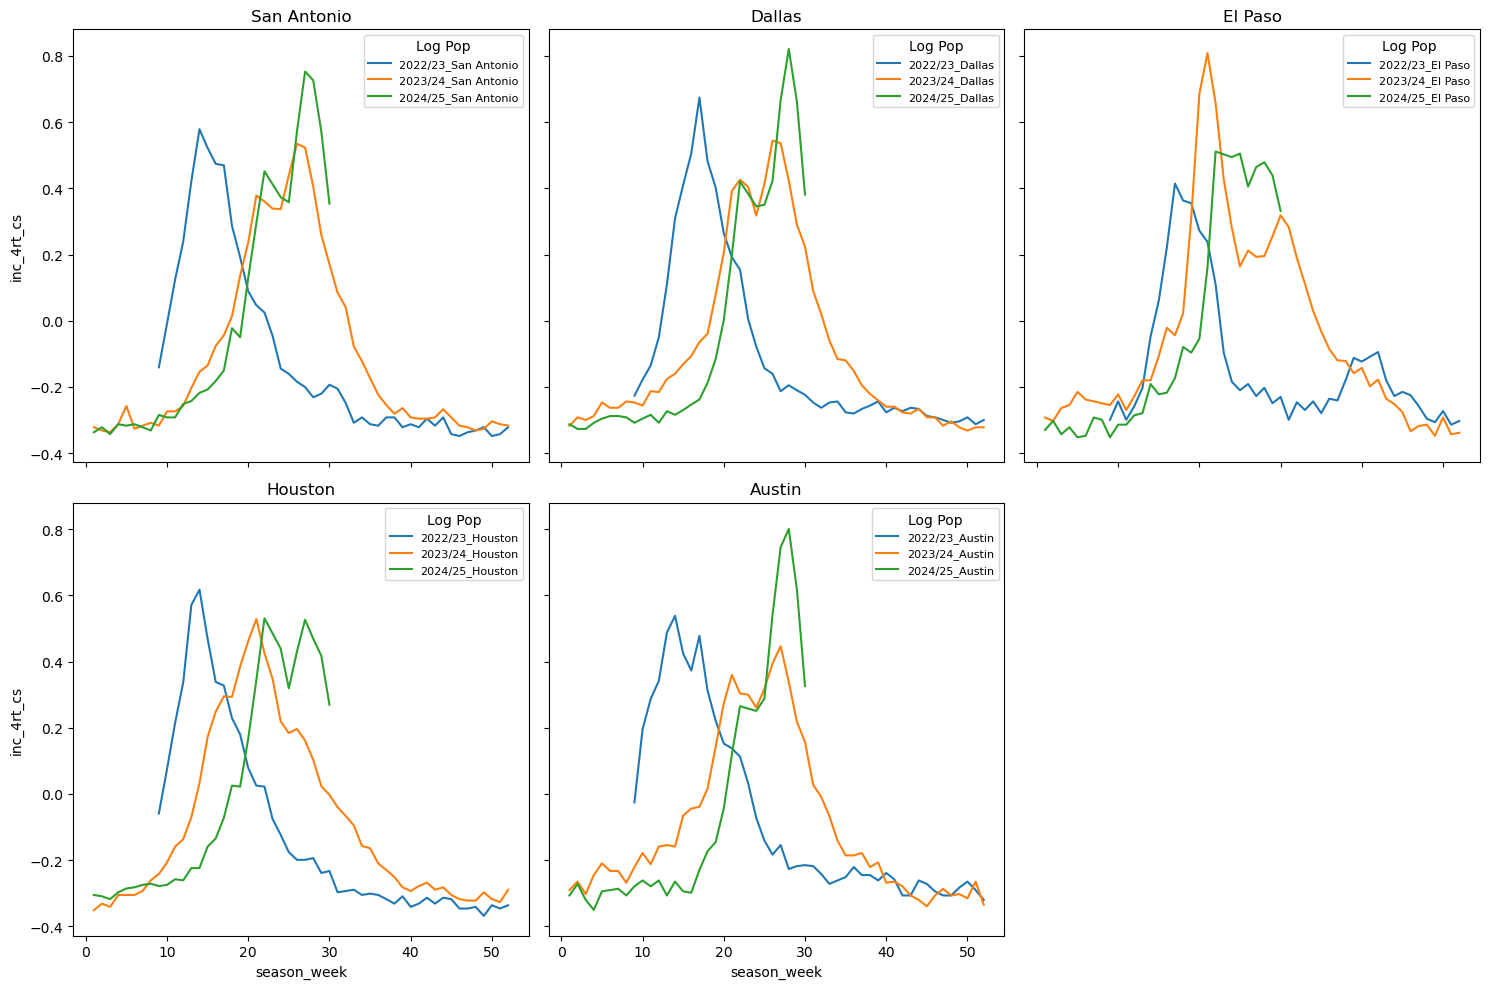

In [46]:
# Filter the DataFrame based on multiple conditions
# Exclude data from the 2020/21 and 2021/22 flu seasons (likely due to COVID-19 disruptions)
# Exclude data between March 1, 2020, and September 1, 2020 (likely due to COVID-19 disruptions)   
filtered_df = df[
    ~df['season'].isin(["2020/21", "2021/22"]) &
    ~((df['wk_end_date'] >= datetime(2020, 3, 1)) & (df['wk_end_date'] <= datetime(2020, 9, 1)))
]
# location 
locations = filtered_df['location'].unique()
nhsn_to_plot = filtered_df.assign(season_loc = lambda x: x['season'] + '_' + x['location'])

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()  # 2D 배열을 1D로 평탄화

# figures by locations
for i, location in enumerate(locations):
    ax = axes[i]  # 각 subplot에 접근
    sns.lineplot(
        data=nhsn_to_plot[nhsn_to_plot['location'] == location],  # 특정 location 데이터만 선택
        x='season_week',
        y='inc_4rt_cs',
        units='season_loc',
        hue='season_loc',  # 색상은 log_pop 기준
        estimator=None,
        ci=None,
        ax=ax
    )
    ax.set_title(location)  # subplot 제목 설정
    ax.legend(title="Log Pop", fontsize=8)  # 범례 설정

# 빈 subplot 숨기기 (location 수가 6보다 적을 경우)
for j in range(len(locations), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [47]:
df = filtered_df

# we already have incidence (transformed scale), season week and log population
feat_names = ['inc_4rt_cs', 'season_week', 'log_pop']

# one-hot encodings of data source, agg_level, and location
for c in ['location']:
    ohe = pd.get_dummies(df[c], prefix=c)
    df = pd.concat([df, ohe], axis=1)
    feat_names = feat_names + list(ohe.columns)

# season week relative to christmas
df = df.merge(
    loader.get_holidays() \
      .query("holiday == 'Christmas Day'") \
      .drop(columns=['holiday', 'date']) \
      .rename(columns={'season_week': 'xmas_week'}),
    how='left',
    on='season') \
  .assign(delta_xmas = lambda x: x['season_week'] - x['xmas_week'])

feat_names = feat_names + ['delta_xmas']

In [48]:
df

,wk_end_date,location,inc,pop,epiweek,year,season_week,season,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor,location_Austin,location_Dallas,location_El Paso,location_Houston,location_San Antonio,xmas_week,delta_xmas
0,2022-10-01,San Antonio,0.78,1434625,39,2022,9,2022/23,14.176414,0.888819,2.906234,-0.140535,0.445318,0,0,0,0,1,22.0,-13.0
1,2022-10-01,Dallas,0.40,1304379,39,2022,9,2022/23,14.081238,0.640312,2.775587,-0.226383,0.456249,0,1,0,0,0,22.0,-13.0
2,2022-10-01,El Paso,0.27,678815,39,2022,9,2022/23,13.428104,0.529150,2.665953,-0.299241,0.496984,0,0,1,0,0,22.0,-13.0
3,2022-10-01,Houston,1.21,2304580,39,2022,9,2022/23,14.650409,1.104536,2.488874,-0.059071,0.501084,0,0,0,1,0,22.0,-13.0
4,2022-10-01,Austin,1.38,961855,39,2022,9,2022/23,13.776619,1.178983,2.552035,-0.025326,0.485500,1,0,0,0,0,22.0,-13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,2025-02-15,San Antonio,5.42,1434625,7,2025,30,2024/25,14.176414,2.330236,2.906234,0.353738,0.445318,0,0,0,0,1,NaN,NaN
621,2025-02-15,Dallas,5.43,1304379,7,2025,30,2024/25,14.081238,2.332381,2.775587,0.381054,0.456249,0,1,0,0,0,NaN,NaN
622,2025-02-15,El Paso,4.91,678815,7,2025,30,2024/25,13.428104,2.218107,2.665953,0.331920,0.496984,0,0,1,0,0,NaN,NaN
623,2025-02-15,Houston,3.70,2304580,7,2025,30,2024/25,14.650409,1.926136,2.488874,0.269717,0.501084,0,0,0,1,0,NaN,NaN


In [49]:
feat_names

['inc_4rt_cs',
 'season_week',
 'log_pop',
 'location_Austin',
 'location_Dallas',
 'location_El Paso',
 'location_Houston',
 'location_San Antonio',
 'delta_xmas']

In [50]:
df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 2,
                'window_align': 'trailing',
                'window_size': [4, 6],
                'fill_edges': False
            }
        },
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 1,
                'window_align': 'trailing',
                'window_size': [3, 5],
                'fill_edges': False
            }
        },
        {
            'fun': 'rollmean',
            'args': {
                'columns': 'inc_4rt_cs',
                'group_columns': ['location'],
                'window_size': [2, 4]
            }
        }
    ])
feat_names = feat_names + new_feat_names

df, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'lag',
            'args': {
                'columns': ['inc_4rt_cs'] + new_feat_names,
                'lags': [1, 2]
            }
        }
    ])
feat_names = feat_names + new_feat_names

print(df)
print(feat_names)

    wk_end_date     location   inc      pop  epiweek  year season_week  \
0    2022-10-01  San Antonio  0.78  1434625       39  2022           9   
1    2022-10-01       Dallas  0.40  1304379       39  2022           9   
2    2022-10-01      El Paso  0.27   678815       39  2022           9   
3    2022-10-01      Houston  1.21  2304580       39  2022           9   
4    2022-10-01       Austin  1.38   961855       39  2022           9   
..          ...          ...   ...      ...      ...   ...         ...   
620  2025-02-15  San Antonio  5.42  1434625        7  2025          30   
621  2025-02-15       Dallas  5.43  1304379        7  2025          30   
622  2025-02-15      El Paso  4.91   678815        7  2025          30   
623  2025-02-15      Houston  3.70  2304580        7  2025          30   
624  2025-02-15       Austin  4.31   961855        7  2025          30   

      season    log_pop   inc_4rt  ...  \
0    2022/23  14.176414  0.888819  ...   
1    2022/23  14.081238  0.

/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/src/timeseriesutils/src/timeseriesutils/featurize.py:507: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(taylor_coefs_one_column_grp,
/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/src/timeseriesutils/src/timeseriesutils/featurize.py:507: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this w

In [51]:
df.shape

(625, 58)

In [52]:
new_feat_names

['inc_4rt_cs_lag1',
 'inc_4rt_cs_lag2',
 'inc_4rt_cs_taylor_d2_c0_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c0_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c1_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c1_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c2_w4t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c2_w4t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c0_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c0_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c1_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c1_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d2_c2_w6t_sNone_lag1',
 'inc_4rt_cs_taylor_d2_c2_w6t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c0_w3t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c0_w3t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c1_w3t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c1_w3t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2',
 'inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1',
 'inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2',
 'inc_4rt_cs_rollmean_w2_lag1',
 'inc_4rt_cs_rollmean_w2_lag2',
 'inc_4rt_cs_rollmean_w4_lag1',
 'in

In [53]:
# import importlib
# featurize = importlib.reload(featurize)

# last date with observed data
# last_obs_date = pd.to_datetime(df.groupby(['location', 'pathogen_covid'])['date'].max().min())
# print(f'last_obs_date: {last_obs_date}')

# how far out to forecast to get to 28 days after due date
# due_date = forecast_date
# extra_horizons_rel_obs = (due_date - last_obs_date.date()).days
# effective_horizon_rel_obs = max_horizon + extra_horizons_rel_obs

# add forecast targets
df_with_pred_targets, new_feat_names = featurize.featurize_data(
    df, group_columns=['location'],
    features = [
        {
            'fun': 'horizon_targets',
            'args': {
                'columns': 'inc_4rt_cs',
                'horizons': [(i+1) for i in range(max_horizon)]
            }
        }
    ])
feat_names = feat_names + new_feat_names

# we will model the differences between the prediction target and the most
# recent observed value
df_with_pred_targets['delta_target'] = df_with_pred_targets['inc_4rt_cs_target'] - df_with_pred_targets['inc_4rt_cs']

print(new_feat_names)
print(df_with_pred_targets)

['horizon']
    wk_end_date     location   inc      pop  epiweek  year season_week  \
0    2022-10-01  San Antonio  0.78  1434625       39  2022           9   
1    2022-10-01       Dallas  0.40  1304379       39  2022           9   
2    2022-10-01      El Paso  0.27   678815       39  2022           9   
3    2022-10-01      Houston  1.21  2304580       39  2022           9   
4    2022-10-01       Austin  1.38   961855       39  2022           9   
..          ...          ...   ...      ...      ...   ...         ...   
620  2025-02-15  San Antonio  5.42  1434625        7  2025          30   
621  2025-02-15       Dallas  5.43  1304379        7  2025          30   
622  2025-02-15      El Paso  4.91   678815        7  2025          30   
623  2025-02-15      Houston  3.70  2304580        7  2025          30   
624  2025-02-15       Austin  4.31   961855        7  2025          30   

      season    log_pop   inc_4rt  ...  \
0    2022/23  14.176414  0.888819  ...   
1    2022/23  1

In [54]:
df_with_pred_targets.shape

(3125, 61)

In [55]:
df_with_pred_targets.wk_end_date.max()

Timestamp('2025-02-15 00:00:00')

In [56]:
df_with_pred_targets[df_with_pred_targets['inc_4rt_cs_target'].isna()]


,wk_end_date,location,inc,pop,epiweek,year,season_week,season,log_pop,inc_4rt,...,inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,inc_4rt_cs_rollmean_w2_lag1,inc_4rt_cs_rollmean_w2_lag2,inc_4rt_cs_rollmean_w4_lag1,inc_4rt_cs_rollmean_w4_lag2,inc_4rt_cs_target,horizon,delta_target
620,2025-02-15,San Antonio,5.42,1434625,7,2025,30,2024/25,14.176414,2.330236,...,0.776832,0.058108,0.110124,0.039309,-0.212802,-0.023568,-0.229849,NaN,1,NaN
621,2025-02-15,Dallas,5.43,1304379,7,2025,30,2024/25,14.081238,2.332381,...,0.774549,0.102254,0.126673,0.211697,-0.194835,0.087746,-0.212495,NaN,1,NaN
622,2025-02-15,El Paso,4.91,678815,7,2025,30,2024/25,13.428104,2.218107,...,0.455324,-0.005750,-0.007177,0.373210,-0.166132,0.206260,-0.189467,NaN,1,NaN
623,2025-02-15,Houston,3.70,2304580,7,2025,30,2024/25,14.650409,1.926136,...,0.490357,0.023583,0.026753,0.412433,-0.086445,0.312065,-0.140640,NaN,1,NaN
624,2025-02-15,Austin,4.31,961855,7,2025,30,2024/25,13.776619,2.078461,...,0.836798,0.091992,0.155706,0.365752,-0.036205,0.369481,-0.101169,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,2025-02-15,San Antonio,5.42,1434625,7,2025,30,2024/25,14.176414,2.330236,...,0.776832,0.058108,0.110124,0.039309,-0.212802,-0.023568,-0.229849,NaN,5,NaN
621,2025-02-15,Dallas,5.43,1304379,7,2025,30,2024/25,14.081238,2.332381,...,0.774549,0.102254,0.126673,0.211697,-0.194835,0.087746,-0.212495,NaN,5,NaN
622,2025-02-15,El Paso,4.91,678815,7,2025,30,2024/25,13.428104,2.218107,...,0.455324,-0.005750,-0.007177,0.373210,-0.166132,0.206260,-0.189467,NaN,5,NaN
623,2025-02-15,Houston,3.70,2304580,7,2025,30,2024/25,14.650409,1.926136,...,0.490357,0.023583,0.026753,0.412433,-0.086445,0.312065,-0.140640,NaN,5,NaN


In [57]:
df_with_pred_targets2 = df_with_pred_targets.query("season_week >= 5 and season_week <= 45")

In [58]:
df_with_pred_targets2.shape

(2575, 61)

In [59]:
#date_list <- c("2023-10-01", "2023-11-05", "2023-12-10", "2024-01-14", "2024-02-18", "2024-03-24")

In [60]:
#df_with_pred_targets = df_with_pred_targets2
df_with_pred_targets = df_with_pred_targets2.drop(columns=['epiweek'])
    

# "test set" df used to generate look-ahead predictions
df_test = df_with_pred_targets \
    .loc[df_with_pred_targets.wk_end_date == df_with_pred_targets.wk_end_date.max()] \
    .copy()

x_test = df_test[feat_names]

# "train set" df for model fitting; target value non-missing
df_train = df_with_pred_targets.loc[~df_with_pred_targets['delta_target'].isna().values]
x_train = df_train[feat_names]
y_train = df_train['delta_target']

In [61]:
df_test

,wk_end_date,location,inc,pop,year,season_week,season,log_pop,inc_4rt,inc_4rt_scale_factor,...,inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,inc_4rt_cs_rollmean_w2_lag1,inc_4rt_cs_rollmean_w2_lag2,inc_4rt_cs_rollmean_w4_lag1,inc_4rt_cs_rollmean_w4_lag2,inc_4rt_cs_target,horizon,delta_target
620,2025-02-15,San Antonio,5.42,1434625,2025,30,2024/25,14.176414,2.330236,2.906234,...,0.776832,0.058108,0.110124,0.039309,-0.212802,-0.023568,-0.229849,NaN,1,NaN
621,2025-02-15,Dallas,5.43,1304379,2025,30,2024/25,14.081238,2.332381,2.775587,...,0.774549,0.102254,0.126673,0.211697,-0.194835,0.087746,-0.212495,NaN,1,NaN
622,2025-02-15,El Paso,4.91,678815,2025,30,2024/25,13.428104,2.218107,2.665953,...,0.455324,-0.005750,-0.007177,0.373210,-0.166132,0.206260,-0.189467,NaN,1,NaN
623,2025-02-15,Houston,3.70,2304580,2025,30,2024/25,14.650409,1.926136,2.488874,...,0.490357,0.023583,0.026753,0.412433,-0.086445,0.312065,-0.140640,NaN,1,NaN
624,2025-02-15,Austin,4.31,961855,2025,30,2024/25,13.776619,2.078461,2.552035,...,0.836798,0.091992,0.155706,0.365752,-0.036205,0.369481,-0.101169,NaN,1,NaN
620,2025-02-15,San Antonio,5.42,1434625,2025,30,2024/25,14.176414,2.330236,2.906234,...,0.776832,0.058108,0.110124,0.039309,-0.212802,-0.023568,-0.229849,NaN,2,NaN
621,2025-02-15,Dallas,5.43,1304379,2025,30,2024/25,14.081238,2.332381,2.775587,...,0.774549,0.102254,0.126673,0.211697,-0.194835,0.087746,-0.212495,NaN,2,NaN
622,2025-02-15,El Paso,4.91,678815,2025,30,2024/25,13.428104,2.218107,2.665953,...,0.455324,-0.005750,-0.007177,0.373210,-0.166132,0.206260,-0.189467,NaN,2,NaN
623,2025-02-15,Houston,3.70,2304580,2025,30,2024/25,14.650409,1.926136,2.488874,...,0.490357,0.023583,0.026753,0.412433,-0.086445,0.312065,-0.140640,NaN,2,NaN
624,2025-02-15,Austin,4.31,961855,2025,30,2024/25,13.776619,2.078461,2.552035,...,0.836798,0.091992,0.155706,0.365752,-0.036205,0.369481,-0.101169,NaN,2,NaN


In [62]:
import warnings


# seed for random number generation, based on reference date
rng_seed = int(time.mktime(ref_date.timetuple()))
rng = np.random.default_rng(seed=rng_seed)
# seeds for lgb model fits, one per combination of bag and quantile level
lgb_seeds = rng.integers(1e8, size=(num_bags, len(q_levels)))

# training loop over bags
# for q_level, q_label in zip(q_levels, q_labels):
    # print(q_label)

oob_preds_by_bag = np.empty((x_train.shape[0], num_bags, len(q_levels)))
oob_preds_by_bag[:] = np.nan
test_preds_by_bag = np.empty((x_test.shape[0], num_bags, len(q_levels)))

train_seasons = df_train['season'].unique()

# Convert season_week and delta_xmas to numeric
x_train['season_week'] = pd.to_numeric(x_train['season_week'], errors='coerce')
x_train['delta_xmas'] = pd.to_numeric(x_train['delta_xmas'], errors='coerce')

x_test['season_week'] = pd.to_numeric(x_test['season_week'], errors='coerce')
x_test['delta_xmas'] = pd.to_numeric(x_test['delta_xmas'], errors='coerce')

#print(x_train.dtypes[x_train.dtypes == 'object'])
#print(x_test.dtypes[x_test.dtypes == 'object'])
# Initialize a DataFrame to store feature importances
feature_importance_df = pd.DataFrame(0, index=x_train.columns, columns=range(num_bags * len(q_levels)))

# Suppress specific warnings
warnings.simplefilter(action="ignore", category=DeprecationWarning)

for b in range(num_bags):
    print(f'bag number {b+1}')
    # get indices of observations that are in bag
    bag_seasons = rng.choice(
        train_seasons,
        size = int(len(train_seasons) * bag_frac_samples),
        replace=False)
    bag_obs_inds = df_train['season'].isin(bag_seasons)
    
    for q_ind, q_level in enumerate(q_levels):
        # fit to bag
        model = lgb.LGBMRegressor(verbosity=-1,
                                    # hist_pool_size=1000,
                                    # objective='mean_absolute_error')
                                    objective='quantile',
                                    alpha = q_level,
                                    random_state=lgb_seeds[b, q_ind])
        model.fit(X=x_train.loc[bag_obs_inds, :], y=y_train.loc[bag_obs_inds])
        
        # oob predictions and test set predictions
        #oob_preds_by_bag[~bag_obs_inds, b, q_ind] = model.predict(X=x_train.loc[~bag_obs_inds, :])
        test_preds_by_bag[:, b, q_ind] = model.predict(X=x_test)

        # Save feature importances
        col_idx = b * len(q_levels) + q_ind
        feature_importance_df.iloc[:, col_idx] = model.feature_importances_


# df_train['oob_pred'] = np.nanmedian(oob_preds_by_bag, axis=1)
# df_test['delta_hat_stage1'] = np.median(test_preds_by_bag, axis=1)


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_90950/417496418.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['season_week'] = pd.to_numeric(x_train['season_week'], errors='coerce')
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_90950/417496418.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['delta_xmas'] = pd.to_numeric(x_train['delta_xmas'], errors='coerce')
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_90950/417496418.py:24: SettingWithCopyW

bag number 1
bag number 2
bag number 3
bag number 4
bag number 5
bag number 6
bag number 7
bag number 8
bag number 9
bag number 10
bag number 11
bag number 12
bag number 13
bag number 14
bag number 15
bag number 16
bag number 17
bag number 18
bag number 19
bag number 20
bag number 21
bag number 22
bag number 23
bag number 24
bag number 25
bag number 26
bag number 27
bag number 28
bag number 29
bag number 30
bag number 31
bag number 32
bag number 33
bag number 34
bag number 35
bag number 36
bag number 37
bag number 38
bag number 39
bag number 40
bag number 41
bag number 42
bag number 43
bag number 44
bag number 45
bag number 46
bag number 47
bag number 48
bag number 49
bag number 50
bag number 51
bag number 52
bag number 53
bag number 54
bag number 55
bag number 56
bag number 57
bag number 58
bag number 59
bag number 60
bag number 61
bag number 62
bag number 63
bag number 64
bag number 65
bag number 66
bag number 67
bag number 68
bag number 69
bag number 70
bag number 71
bag number 72
b

In [63]:
feature_importance_df['average_importance'] = feature_importance_df.mean(axis=1)
feature_importance_df = feature_importance_df.sort_values(by='average_importance', ascending=False)
feature_importance_df

,0,1,2,3,4,5,6,7,8,9,...,891,892,893,894,895,896,897,898,899,average_importance
horizon,151,265,330,367,446,386,300,242,160,147,...,147,255,307,421,483,389,285,258,156,302.237778
inc_4rt_cs,343,237,177,173,141,112,167,213,240,357,...,357,255,175,135,132,134,190,199,196,188.980000
season_week,175,164,194,149,141,120,130,115,99,102,...,102,88,108,119,63,98,70,77,60,113.148889
inc_4rt_cs_rollmean_w2,85,81,99,111,108,129,96,100,122,80,...,80,92,114,100,130,121,109,130,157,109.491111
inc_4rt_cs_rollmean_w4,45,85,96,109,111,129,104,97,114,70,...,70,74,92,100,89,92,105,114,106,92.542222
inc_4rt_cs_taylor_d2_c1_w4t_sNone,69,116,92,85,86,72,70,100,65,71,...,71,105,83,79,82,69,83,61,69,81.214444
inc_4rt_cs_rollmean_w4_lag2,66,84,76,76,75,94,73,102,77,28,...,28,47,64,75,79,121,101,77,66,75.414444
log_pop,72,70,92,73,80,79,103,101,103,37,...,37,79,74,49,62,54,82,70,80,74.157778
inc_4rt_cs_taylor_d2_c2_w4t_sNone,51,80,68,76,75,73,64,87,108,54,...,54,71,70,76,92,75,75,67,46,73.884444
inc_4rt_cs_rollmean_w2_lag2,72,103,108,93,77,82,76,89,76,46,...,46,46,61,70,86,68,77,70,48,70.537778


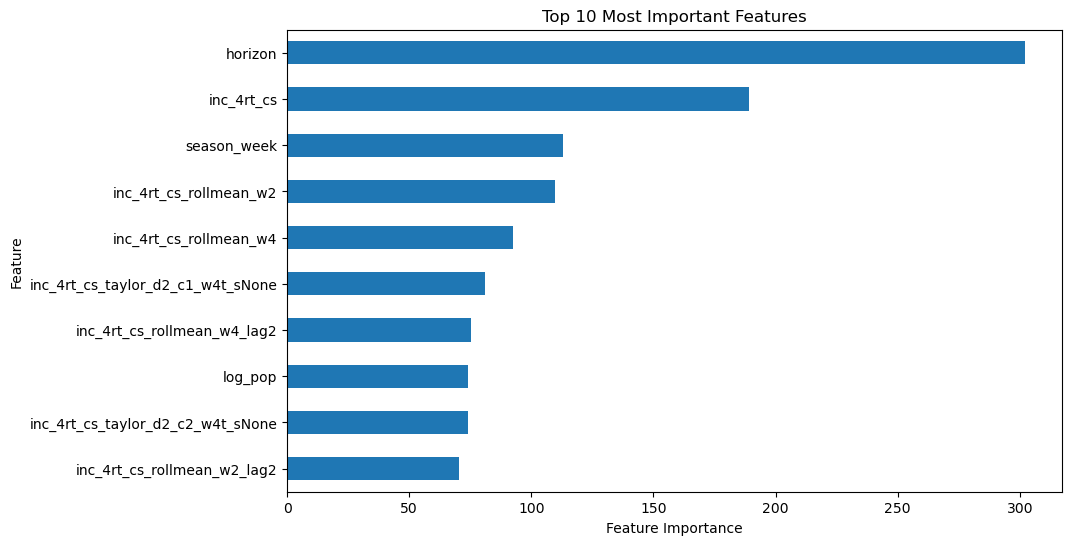

In [64]:
feature_importance_df['average_importance'].head(10).plot(kind='barh', figsize=(10, 6))
plt.title("Top 10 Most Important Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [65]:
#oob_pred_qs = np.nanmedian(oob_preds_by_bag, axis=1)
test_pred_qs = np.median(test_preds_by_bag, axis=1)
test_pred_qs_sorted = np.sort(test_pred_qs, axis=1)  # Sort to enforce monotonicity
test_pred_qs_sorted.shape

test_pred_qs_df = pd.DataFrame(test_pred_qs_sorted)
test_pred_qs_df.columns = q_labels
test_pred_qs_df

,0.025,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.975
0,-0.255379,-0.192331,-0.188474,-0.114438,-0.090288,-0.079151,-0.062108,-0.060323,0.023376
1,-0.285549,-0.197012,-0.185638,-0.149644,-0.103962,-0.085865,-0.067340,-0.066846,0.006947
2,-0.172156,-0.142102,-0.115984,-0.114997,-0.081070,-0.069966,-0.028040,-0.027481,0.033870
3,-0.169942,-0.134476,-0.122772,-0.088667,-0.067206,-0.055558,-0.037430,-0.024334,0.041754
4,-0.262916,-0.179781,-0.176333,-0.116938,-0.103486,-0.078517,-0.065058,-0.055714,0.012065
5,-0.257777,-0.215337,-0.202202,-0.126398,-0.124595,-0.105939,-0.101418,-0.064155,0.021614
6,-0.287610,-0.209930,-0.206717,-0.178988,-0.158414,-0.121331,-0.117601,-0.065275,0.009107
7,-0.167870,-0.156176,-0.147979,-0.142141,-0.130649,-0.119060,-0.083878,-0.021387,0.032835
8,-0.172103,-0.156157,-0.153645,-0.151048,-0.116312,-0.084162,-0.045947,-0.030330,0.039993
9,-0.262916,-0.208452,-0.188146,-0.150261,-0.135806,-0.104620,-0.104522,-0.059218,0.010823


In [66]:
df_test.reset_index(drop=True, inplace=True)
df_test_w_preds = pd.concat([df_test, test_pred_qs_df], axis=1)
df_test_w_preds

,wk_end_date,location,inc,pop,year,season_week,season,log_pop,inc_4rt,inc_4rt_scale_factor,...,delta_target,0.025,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.975
0,2025-02-15,San Antonio,5.42,1434625,2025,30,2024/25,14.176414,2.330236,2.906234,...,NaN,-0.255379,-0.192331,-0.188474,-0.114438,-0.090288,-0.079151,-0.062108,-0.060323,0.023376
1,2025-02-15,Dallas,5.43,1304379,2025,30,2024/25,14.081238,2.332381,2.775587,...,NaN,-0.285549,-0.197012,-0.185638,-0.149644,-0.103962,-0.085865,-0.067340,-0.066846,0.006947
2,2025-02-15,El Paso,4.91,678815,2025,30,2024/25,13.428104,2.218107,2.665953,...,NaN,-0.172156,-0.142102,-0.115984,-0.114997,-0.081070,-0.069966,-0.028040,-0.027481,0.033870
3,2025-02-15,Houston,3.70,2304580,2025,30,2024/25,14.650409,1.926136,2.488874,...,NaN,-0.169942,-0.134476,-0.122772,-0.088667,-0.067206,-0.055558,-0.037430,-0.024334,0.041754
4,2025-02-15,Austin,4.31,961855,2025,30,2024/25,13.776619,2.078461,2.552035,...,NaN,-0.262916,-0.179781,-0.176333,-0.116938,-0.103486,-0.078517,-0.065058,-0.055714,0.012065
5,2025-02-15,San Antonio,5.42,1434625,2025,30,2024/25,14.176414,2.330236,2.906234,...,NaN,-0.257777,-0.215337,-0.202202,-0.126398,-0.124595,-0.105939,-0.101418,-0.064155,0.021614
6,2025-02-15,Dallas,5.43,1304379,2025,30,2024/25,14.081238,2.332381,2.775587,...,NaN,-0.287610,-0.209930,-0.206717,-0.178988,-0.158414,-0.121331,-0.117601,-0.065275,0.009107
7,2025-02-15,El Paso,4.91,678815,2025,30,2024/25,13.428104,2.218107,2.665953,...,NaN,-0.167870,-0.156176,-0.147979,-0.142141,-0.130649,-0.119060,-0.083878,-0.021387,0.032835
8,2025-02-15,Houston,3.70,2304580,2025,30,2024/25,14.650409,1.926136,2.488874,...,NaN,-0.172103,-0.156157,-0.153645,-0.151048,-0.116312,-0.084162,-0.045947,-0.030330,0.039993
9,2025-02-15,Austin,4.31,961855,2025,30,2024/25,13.776619,2.078461,2.552035,...,NaN,-0.262916,-0.208452,-0.188146,-0.150261,-0.135806,-0.104620,-0.104522,-0.059218,0.010823


In [67]:
# delta_names = [f'delta_hat_q{q_label}' for q_label in q_labels]
cols_to_keep = ['wk_end_date' ,'location', 'pop',
                'inc_4rt_cs', 'horizon',
                'inc_4rt_center_factor', 'inc_4rt_scale_factor']
preds_df = df_test_w_preds[cols_to_keep + q_labels]
preds_df = pd.melt(preds_df,
                id_vars=cols_to_keep,
                var_name='quantile',
                value_name = 'delta_hat')
preds_df

,wk_end_date,location,pop,inc_4rt_cs,horizon,inc_4rt_center_factor,inc_4rt_scale_factor,quantile,delta_hat
0,2025-02-15,San Antonio,1434625,0.353738,1,0.445318,2.906234,0.025,-0.255379
1,2025-02-15,Dallas,1304379,0.381054,1,0.456249,2.775587,0.025,-0.285549
2,2025-02-15,El Paso,678815,0.331920,1,0.496984,2.665953,0.025,-0.172156
3,2025-02-15,Houston,2304580,0.269717,1,0.501084,2.488874,0.025,-0.169942
4,2025-02-15,Austin,961855,0.325754,1,0.485500,2.552035,0.025,-0.262916
...,...,...,...,...,...,...,...,...,...
220,2025-02-15,San Antonio,1434625,0.353738,5,0.445318,2.906234,0.975,0.062486
221,2025-02-15,Dallas,1304379,0.381054,5,0.456249,2.775587,0.975,0.063696
222,2025-02-15,El Paso,678815,0.331920,5,0.496984,2.665953,0.975,0.096679
223,2025-02-15,Houston,2304580,0.269717,5,0.501084,2.488874,0.975,0.100977


In [68]:
# build data frame with predictions on the original scale
preds_df['inc_4rt_cs_target_hat'] = preds_df['inc_4rt_cs'] + preds_df['delta_hat']
preds_df['inc_4rt_target_hat'] = (preds_df['inc_4rt_cs_target_hat'] + preds_df['inc_4rt_center_factor']) * (preds_df['inc_4rt_scale_factor'] + 0.01)
preds_df['value'] = (np.maximum(preds_df['inc_4rt_target_hat'], 0.0) ** 2 - 0.01) 
preds_df['value'] = np.maximum(preds_df['value'], 0.0)
preds_df

,wk_end_date,location,pop,inc_4rt_cs,horizon,inc_4rt_center_factor,inc_4rt_scale_factor,quantile,delta_hat,inc_4rt_cs_target_hat,inc_4rt_target_hat,value
0,2025-02-15,San Antonio,1434625,0.353738,1,0.445318,2.906234,0.025,-0.255379,0.098359,1.585491,2.503783
1,2025-02-15,Dallas,1304379,0.381054,1,0.456249,2.775587,0.025,-0.285549,0.095504,1.536958,2.352240
2,2025-02-15,El Paso,678815,0.331920,1,0.496984,2.665953,0.025,-0.172156,0.159764,1.757425,3.078543
3,2025-02-15,Houston,2304580,0.269717,1,0.501084,2.488874,0.025,-0.169942,0.099776,1.501473,2.244422
4,2025-02-15,Austin,961855,0.325754,1,0.485500,2.552035,0.025,-0.262916,0.062838,1.404862,1.963636
...,...,...,...,...,...,...,...,...,...,...,...,...
220,2025-02-15,San Antonio,1434625,0.353738,5,0.445318,2.906234,0.975,0.062486,0.416224,2.512459,6.302451
221,2025-02-15,Dallas,1304379,0.381054,5,0.456249,2.775587,0.975,0.063696,0.444750,2.509813,6.289160
222,2025-02-15,El Paso,678815,0.331920,5,0.496984,2.665953,0.975,0.096679,0.428599,2.476816,6.124615
223,2025-02-15,Houston,2304580,0.269717,5,0.501084,2.488874,0.975,0.100977,0.370694,2.178465,4.735708


In [69]:
# keep just required columns and rename to match hub format
preds_df = preds_df[['wk_end_date', 'location', 'horizon', 'quantile', 'value']] \
    .rename(
        columns={
            'quantile': 'output_type_id'
        })

preds_df['target_end_date'] = preds_df['wk_end_date'] + pd.to_timedelta(7*preds_df['horizon'], unit='days')
preds_df['reference_date'] = ref_date
preds_df['target'] = 'Flu ED visits pct'
preds_df['horizon'] = preds_df['horizon'] - 2

preds_df['output_type'] = 'quantile'
preds_df



,wk_end_date,location,horizon,output_type_id,value,target_end_date,reference_date,target,output_type
0,2025-02-15,San Antonio,-1,0.025,2.503783,2025-02-22,2025-03-01,Flu ED visits pct,quantile
1,2025-02-15,Dallas,-1,0.025,2.352240,2025-02-22,2025-03-01,Flu ED visits pct,quantile
2,2025-02-15,El Paso,-1,0.025,3.078543,2025-02-22,2025-03-01,Flu ED visits pct,quantile
3,2025-02-15,Houston,-1,0.025,2.244422,2025-02-22,2025-03-01,Flu ED visits pct,quantile
4,2025-02-15,Austin,-1,0.025,1.963636,2025-02-22,2025-03-01,Flu ED visits pct,quantile
...,...,...,...,...,...,...,...,...,...
220,2025-02-15,San Antonio,3,0.975,6.302451,2025-03-22,2025-03-01,Flu ED visits pct,quantile
221,2025-02-15,Dallas,3,0.975,6.289160,2025-03-22,2025-03-01,Flu ED visits pct,quantile
222,2025-02-15,El Paso,3,0.975,6.124615,2025-03-22,2025-03-01,Flu ED visits pct,quantile
223,2025-02-15,Houston,3,0.975,4.735708,2025-03-22,2025-03-01,Flu ED visits pct,quantile


In [70]:
preds_df = preds_df[['reference_date', 'location', 'horizon', 'target', 'target_end_date', 'output_type', 'output_type_id', 'value']]
preds_df

,reference_date,location,horizon,target,target_end_date,output_type,output_type_id,value
0,2025-03-01,San Antonio,-1,Flu ED visits pct,2025-02-22,quantile,0.025,2.503783
1,2025-03-01,Dallas,-1,Flu ED visits pct,2025-02-22,quantile,0.025,2.352240
2,2025-03-01,El Paso,-1,Flu ED visits pct,2025-02-22,quantile,0.025,3.078543
3,2025-03-01,Houston,-1,Flu ED visits pct,2025-02-22,quantile,0.025,2.244422
4,2025-03-01,Austin,-1,Flu ED visits pct,2025-02-22,quantile,0.025,1.963636
...,...,...,...,...,...,...,...,...
220,2025-03-01,San Antonio,3,Flu ED visits pct,2025-03-22,quantile,0.975,6.302451
221,2025-03-01,Dallas,3,Flu ED visits pct,2025-03-22,quantile,0.975,6.289160
222,2025-03-01,El Paso,3,Flu ED visits pct,2025-03-22,quantile,0.975,6.124615
223,2025-03-01,Houston,3,Flu ED visits pct,2025-03-22,quantile,0.975,4.735708


In [71]:
if not Path('epiENGAGE-GBQR/model_output/TX_NSSP_percent').exists():
    Path('epiENGAGE-GBQR/model_output/TX_NSSP_percent').mkdir(parents=True)

preds_df.to_csv(f'epiENGAGE-GBQR/model_output/TX_NSSP_percent/{str(ref_date)}-epiENGAGE-GBQR.csv', index=False)
